In [2]:
# Cell 1: Imports and Setup
import os
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import cv2

# Set up logging
logging.basicConfig(filename='training.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")
print(f"Using device: {device}")

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Generate a random name for this run
def generate_random_name():
    adjectives = ['swift', 'bold', 'clever', 'dapper', 'eager', 'fierce', 'gentle', 'happy', 'jolly', 'kind']
    nouns = ['panda', 'eagle', 'tiger', 'dolphin', 'koala', 'falcon', 'wolf', 'owl', 'fox', 'bear']
    return f"{random.choice(adjectives)}_{random.choice(nouns)}_{random.randint(1000, 9999)}"

run_name = generate_random_name()
print(f"Run name: {run_name}")

# Create a directory for this run
run_dir = os.path.join('runs', run_name)
os.makedirs(run_dir, exist_ok=True)

# Set up logging to write to a file in the run directory
log_file = os.path.join(run_dir, f'{run_name}.log')
logging.basicConfig(filename=log_file, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Run name: {run_name}")
logging.info(f"Run directory: {run_dir}")

Using device: cpu
Run name: bold_panda_5506


Attempting to load image: data/training/279.tif
Successfully loaded image: data/training/279.tif, shape: (639, 711)
Attempting to load image: data/training/277.tif
Successfully loaded image: data/training/277.tif, shape: (723, 666)
Attempting to load image: data/training/275.tif
Successfully loaded image: data/training/275.tif, shape: (747, 1008)
Attempting to load image: data/training/273.tif
Successfully loaded image: data/training/273.tif, shape: (879, 651)
Attempting to load image: data/training/271.tif
Successfully loaded image: data/training/271.tif, shape: (882, 660)
Attempting to load image: data/training/269.tif
Successfully loaded image: data/training/269.tif, shape: (780, 780)
Attempting to load image: data/training/267.tif
Successfully loaded image: data/training/267.tif, shape: (984, 564)
Attempting to load image: data/training/265.tif
Successfully loaded image: data/training/265.tif, shape: (675, 1251)
Attempting to load image: data/training/263.tif
Successfully loaded im

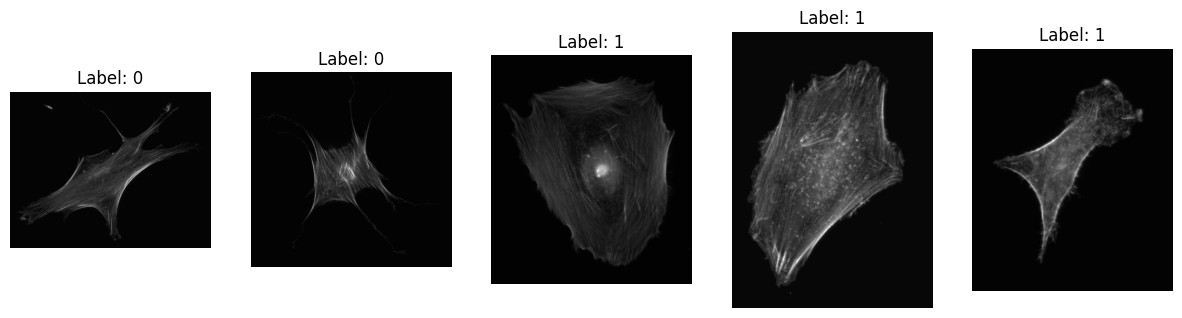

In [3]:
# Cell 2: Data Loading and Preprocessing
def load_and_preprocess_data(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    logging.info(f"Loaded dataframe with shape: {df.shape}")
    df = df.rename(columns={'is_homogenous': 'label'})

    def load_image(image_id):
        img_path = os.path.join(images_dir, f"{str(image_id).zfill(3)}.tif")
        print(f"Attempting to load image: {img_path}")  # Debug print
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found: {img_path}")
            return None
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: Unable to read image: {img_path}")
        else:
            print(f"Successfully loaded image: {img_path}, shape: {img.shape}")  # Debug print
        return img

    df['image_array'] = df['image_id '].apply(load_image)
    
    print(f"Total images: {len(df)}")
    print(f"Successfully loaded images: {df['image_array'].notna().sum()}")
    print(f"Failed to load images: {df['image_array'].isna().sum()}")
    
    # Print a few rows to inspect the dataframe
    print(df[['image_id ', 'label', 'image_array']].head())

    return df

# Load and preprocess data
csv_path = 'data/training.csv'
images_dir = 'data/training'
df = load_and_preprocess_data(csv_path, images_dir)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Log sizes of train and validation distributions
logging.info(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")
logging.info(f"Train class distribution: {train_df['label'].value_counts().to_dict()}")
logging.info(f"Validation class distribution: {val_df['label'].value_counts().to_dict()}")

# Plot some images from the training set
import matplotlib.pyplot as plt

def plot_images(dataframe, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(dataframe['image_array'].iloc[i], cmap='gray')
        plt.title(f"Label: {dataframe['label'].iloc[i]}")
        plt.axis('off')
    plt.show()

plot_images(train_df)

In [8]:
# Cell 3: Dataset and DataLoader Creation
class BalancedCellDataset(Dataset):
    def __init__(self, dataframe, transform=None, minority_transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.minority_transform = minority_transform

    def __getitem__(self, idx):
        img_array = self.dataframe.iloc[idx]['image_array']
        label = self.dataframe.iloc[idx]['label']

        if img_array is None:
            print(f"Warning: Image at index {idx} is None. Skipping this image.")
            return None, label

        try:
            img_array = (img_array / 256).astype(np.uint8)
        except TypeError:
            print(f"Error: Unable to process image at index {idx}. Image array type: {type(img_array)}")
            return None, label

        if label == 1 and self.minority_transform:  # Apply more augmentation to minority class
            img_array = self.minority_transform(img_array)
        elif self.transform:
            img_array = self.transform(img_array)

        return img_array, label

    def __len__(self):
        return len(self.dataframe) 

def create_balanced_sampler(dataset):
    class_counts = dataset.dataframe['label'].value_counts().sort_index()
    weights = 1. / class_counts[dataset.dataframe['label']]
    samples_weight = torch.from_numpy(weights.values)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

minority_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create datasets and dataloaders
train_dataset = BalancedCellDataset(train_df, transform=transform, minority_transform=minority_transform)
val_dataset = BalancedCellDataset(val_df, transform=transform)

sampler = create_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [9]:
# Cell 4: Data Visualization
def plot_sample_images(dataset, num_samples=5, title="Sample Images"):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        
        if img is None:
            print(f"Warning: Image at index {idx} is None. Skipping this image.")
            continue
        
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, f'{title.lower().replace(" ", "_")}.png'))
    plt.close()

# Plot pre-transform images
plot_sample_images(train_dataset, title="Pre-transform Train Images")
plot_sample_images(val_dataset, title="Pre-transform Validation Images")

# Create transformed datasets for post-transform images
transformed_train_dataset = BalancedCellDataset(train_df, transform=transform)
transformed_val_dataset = BalancedCellDataset(val_df, transform=transform)

# Plot post-transform images
plot_sample_images(transformed_train_dataset, title="Post-transform Train Images")
plot_sample_images(transformed_val_dataset, title="Post-transform Validation Images")

In [ ]:
# Cell 5: Model Definition and Training
def calculate_custom_score(y_true, y_pred):
    n0 = sum(1 for label in y_true if label == 0)
    n1 = sum(1 for label in y_true if label == 1)
    a0 = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    a1 = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    return (a0 * a1) / (n0 * n1) if (n0 * n1) != 0 else 0

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5):
    train_losses, train_accuracies, train_scores = [], [], []
    val_losses, val_accuracies, val_scores = [], [], []
    
    best_custom_score = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_score = calculate_custom_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_scores.append(train_score)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_score = calculate_custom_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_scores.append(val_score)

        # Learning rate scheduling
        scheduler.step(val_score)

        # Early stopping
        if val_score > best_custom_score:
            best_custom_score = val_score
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

        # Logging
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        logging.info(f"Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        logging.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")
        logging.info(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        print(f"Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
        print("-" * 50)
    
    return train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores

# Define model, loss function, optimizer, and scheduler
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Train the model
num_epochs = 20
logging.info("Starting training...")
train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs
)
logging.info("Training completed.")

In [ ]:
# Cell 6: Evaluation and Results Visualization
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy()) 
            custom_score = calculate_custom_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)
    
    return custom_score, f1, precision, recall, auc, all_labels, all_preds

# Evaluate the model
custom_score, f1, precision, recall, auc, all_labels, all_preds = evaluate_model(model, val_loader)

# Log final metrics
logging.info(f"Final Custom Score: {custom_score:.4f}")
logging.info(f"F1 Score: {f1:.4f}")
logging.info(f"Precision: {precision:.4f}")
logging.info(f"Recall: {recall:.4f}")
logging.info(f"ROC AUC: {auc:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Heterogeneous', 'Homogeneous'], 
            yticklabels=['Heterogeneous', 'Homogeneous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save Classification Report
class_report = classification_report(all_labels, all_preds)
with open(os.path.join(run_dir, 'classification_report.txt'), 'w') as f:
    f.write("Classification Report:\n")
    f.write(class_report)
    f.write(f"\nFinal Custom Score: {custom_score:.4f}")
    f.write(f"\nROC AUC: {auc:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_scores, label='Train')
plt.plot(val_scores, label='Validation')
plt.title('Custom Score')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'training_curves.png'))
plt.close()

# Save metrics as CSV
metrics_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'train_score': train_scores,
    'val_score': val_scores
})
metrics_df.to_csv(os.path.join(run_dir, 'metrics.csv'), index=False)

print(f"All outputs saved in the directory: {run_dir}")
print("Training and evaluation completed.") 